In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv('datasets/Churn.csv')
print(df.shape)
df.head()

(3333, 21)


,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,...,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,...,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,...,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,...,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.4,61.9,196.9,6.6,2,no,yes,no,...,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.7,148.3,186.9,10.1,3,no,yes,no,...,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


In [7]:
print(df.isnull().sum())
df.dtypes

Account_Length    0
Vmail_Message     0
Day_Mins          0
Eve_Mins          0
Night_Mins        0
Intl_Mins         0
CustServ_Calls    0
Churn             0
Intl_Plan         0
Vmail_Plan        0
Day_Calls         0
Day_Charge        0
Eve_Calls         0
Eve_Charge        0
Night_Calls       0
Night_Charge      0
Intl_Calls        0
Intl_Charge       0
State             0
Area_Code         0
Phone             0
dtype: int64


Account_Length      int64
Vmail_Message       int64
Day_Mins          float64
Eve_Mins          float64
Night_Mins        float64
Intl_Mins         float64
CustServ_Calls      int64
Churn              object
Intl_Plan          object
Vmail_Plan         object
Day_Calls           int64
Day_Charge        float64
Eve_Calls           int64
Eve_Charge        float64
Night_Calls         int64
Night_Charge      float64
Intl_Calls          int64
Intl_Charge       float64
State              object
Area_Code           int64
Phone              object
dtype: object

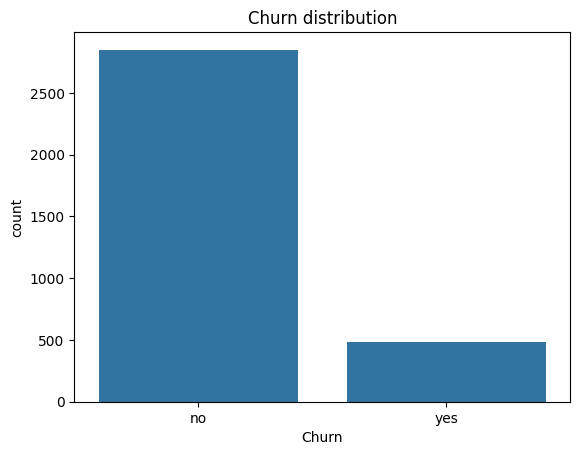

In [8]:
df.describe()

df['Churn'].value_counts(normalize=True)

sns.countplot(data=df, x='Churn')
plt.title('Churn distribution')
plt.show()

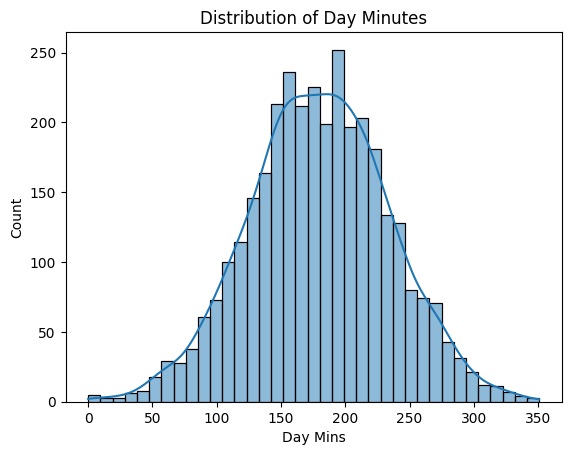

Mean: 179.77509750975094
Std: 54.46738920237142


In [12]:
sns.histplot(df['Day_Mins'], kde=True)
plt.title("Distribution of Day Minutes")
plt.xlabel("Day Mins")
plt.show()

print("Mean:", df['Day_Mins'].mean())
print("Std:", df['Day_Mins'].std())

In [14]:
sample = df['Day_Mins']
mean = sample.mean()
std = sample.std()
n = len(sample)

ci = stats.norm.interval(0.95, loc=mean, scale=std/np.sqrt(n))
print(f"95% Confidence Interval for Day Mins: {ci}")

95% Confidence Interval for Day Mins: (177.92596943322224, 181.62422558627964)


<b>Hypothesis testing:</b> do churned customers make significantly more customer service calls than those who stayed?

In [16]:
from scipy.stats import ttest_ind

churned = df[df['Churn'] == 'yes']['CustServ_Calls']
not_churned = df[df['Churn'] == 'no']['CustServ_Calls']

t_stat, p_value = ttest_ind(churned, not_churned, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")
print("Mean (Churned):", churned.mean())
print("Mean (Not churned):", not_churned.mean())

T-statistic: 8.955
P-value: 0.0000
Mean (Churned): 2.229813664596273
Mean (Not churned): 1.4498245614035088


<b>Chi-Square test:</b> Is there a relationship between having an international plan and churn?

In [17]:
from scipy.stats import chi2_contingency

table = pd.crosstab(df['Intl_Plan'], df['Churn'])

chi2, p, dof, expected = chi2_contingency(table)

print("Chi-square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)

Chi-square Statistic: 222.5657566499376
P-value: 2.4931077033159556e-50
Degrees of Freedom: 1


Since p < 0.05 (in fact, p ≪ 0.00001), we reject the null hypothesis.

    Conclusion: There is a strong and statistically significant relationship between having an International Plan and customer churn.

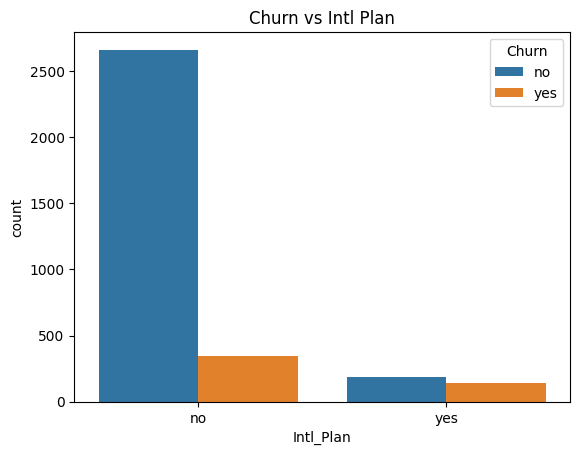

In [19]:
sns.countplot(data=df, x='Intl_Plan', hue='Churn')
plt.title("Churn vs Intl Plan")
plt.show()

<b>Correlation matrix</b>

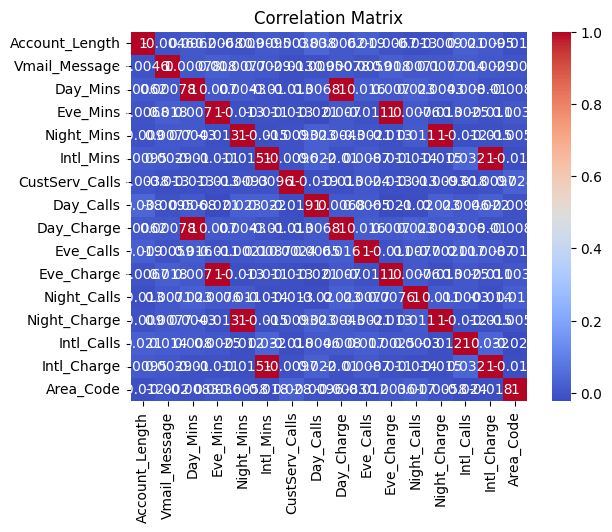

In [20]:
num_cols = df.select_dtypes(include='number')
corr = num_cols.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

<b>Variance Analysis (ANOVA)</b> Check if Day Mins differs across groups like Area_Code.

In [22]:
from scipy.stats import f_oneway

groups = [group['Day_Mins'].values for _, group in df.groupby('Area_Code')]
f_stat, p_val = f_oneway(*groups)

print(f"F-statistic: {f_stat}, P-value: {p_val}")

F-statistic: 2.0152078300949974, P-value: 0.1334552217622214


Since p = 0.133 > 0.05, we fail to reject the null hypothesis. There is no statistically significant difference in Day Mins across Area_Code groups.

<b>Effect Size Measures: Use Cohen’s d to quantify the difference in means.</b>

In [23]:
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    pooled_std = np.sqrt(((nx - 1)*x.std()**2 + (ny - 1)*y.std()**2) / (nx + ny - 2))
    return (x.mean() - y.mean()) / pooled_std

coh_d = cohens_d(churned, not_churned)
print(f"Cohen's d: {coh_d}")

Cohen's d: 0.6061922144281623


The result (0.606) indicate moderate to large effect size: Churned vs non-churned customers differ noticeably in the variable we passed in.

<b>Logistic Regression</b>

In [24]:
import statsmodels.formula.api as smf

df['Churn_Binary'] = df['Churn'].map({'yes': 1, 'no': 0})
model = smf.logit("Churn_Binary ~ Q('CustServ_Calls') + Q('Intl_Plan')", data=df)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.365766
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           Churn_Binary   No. Observations:                 3333
Model:                          Logit   Df Residuals:                     3330
Method:                           MLE   Df Model:                            2
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.1160
Time:                        17:16:06   Log-Likelihood:                -1219.1
converged:                       True   LL-Null:                       -1379.1
Covariance Type:            nonrobust   LLR p-value:                 3.103e-70
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.8677      0.098    -29.354      0.000      -3.059      -2.

Pseudo R-squared: 0.1160 → not great, but okay for logistic models

LLR p-value: 3.1e-70 → model is statistically significant overall

Customers with Intl Plans and frequent service calls are red flags.

<b>ROC Curve and AUC</b>

📈 ROC Curve = Receiver Operating Characteristic Curve

    A plot of: True Positive Rate (Recall) against False Positive Rate

    For every possible threshold of the classifier

🧮 AUC = Area Under the ROC Curve

    A single scalar value summarizing model performance

    Ranges from 0 to 1:

        0.5 = random guessing (useless model)

        1.0 = perfect classifier

        0.7–0.8 = decent

        0.8–0.9 = strong

        >0.9 = excellent (sometimes too good = suspicious)

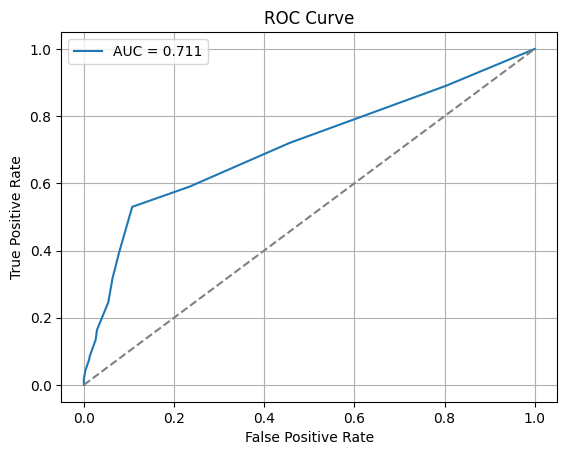

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities from fitted model
df['prob_churn'] = result.predict()  # result from statsmodels Logit

# The true labels
y_true = df['Churn_Binary']
y_scores = df['prob_churn']

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], '--', color='gray')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

<b>Confidence Interval for Proportions</b>

In [26]:
import statsmodels.api as sm
churned = (df['Churn'] == 'yes').sum()
total = len(df)
sm.stats.proportion_confint(churned, total, alpha=0.05, method='wilson')

(0.13337252397333918, 0.15727402630161916)

We have 95% confidence that the true churn rate in the customer population lies between 13.34% and 15.73%.